<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Forecasting-with-sktime" data-toc-modified-id="Forecasting-with-sktime-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Forecasting with sktime</a></span><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preliminaries</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Specifying-the-forecasting-task" data-toc-modified-id="Specifying-the-forecasting-task-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Specifying the forecasting task</a></span><ul class="toc-item"><li><span><a href="#Optimizing-automatically-hyperparameters" data-toc-modified-id="Optimizing-automatically-hyperparameters-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Optimizing automatically hyperparameters</a></span></li></ul></li></ul></li></ul></div>

# Forecasting with sktime

In forecasting, we're interested in using past data to make temporal forward predictions. sktime provides common statistical forecasting algorithms and tools for building composite machine learning models.


<img src="img/forecasting.png" width=750 />

For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.

## Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys

%matplotlib inline

In [2]:
import statsmodels
import sktime
statsmodels.__version__, sktime.__version__

('0.12.0', '0.4.2')

## Data
For this tutorial, we will use the famous Box-Jenkins airline data set, which shows the number of international airline
passengers per month from 1949-1960.

As well as using the original time series (which is a classic example of a *multiplicative* time series), we will create an *additive* time series by performing a log-transform on the original data, so we may compare forecasters against both types of model.

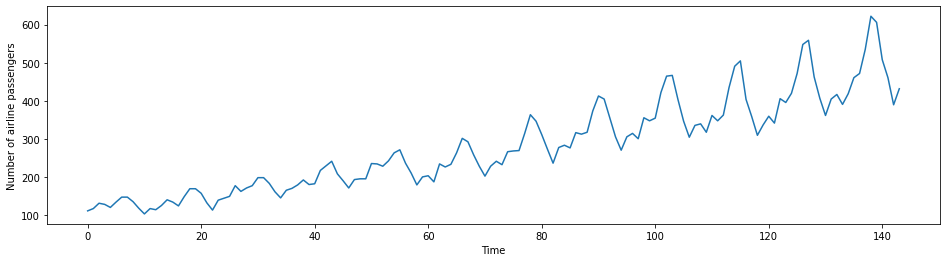

In [3]:
y = load_airline()
fig, ax = plot_ys(y)
ax.set(xlabel="Time", ylabel="Number of airline passengers");

In [4]:
type(y)

pandas.core.series.Series

## Specifying the forecasting task

Next we will define a forecasting task.

* We will try to predict the last 3 years of data, using the previous years as training data. Each point in the series represents a month, so we should hold out the last 36 points as test data, and use 36-step ahead forecasting horizon to evaluate forecasting performance.
* We will use the sMAPE (symmetric mean absolute percentage error) to quantify the accuracy of our forecasts. A lower sMAPE means higher accuracy.

We can split the data as follows:

108 36


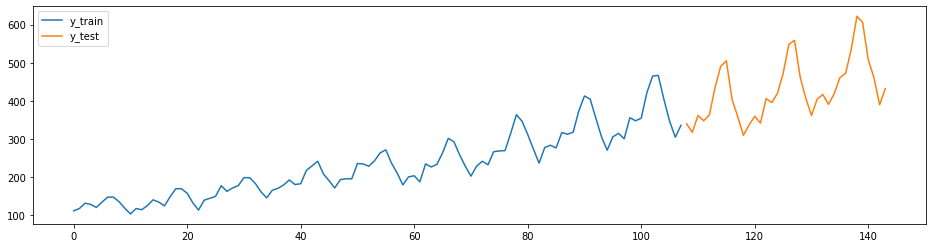

In [5]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_ys(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [6]:
# using sktime 
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

fh     = list(range(1,37))
y_last = forecaster.predict(fh)
type(fh), type(y_last)

(list, pandas.core.series.Series)

In [7]:
y_last.index

Int64Index([108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
            121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
            134, 135, 136, 137, 138, 139, 140, 141, 142, 143],
           dtype='int64')

In [8]:
y_test.index

Int64Index([108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
            121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
            134, 135, 136, 137, 138, 139, 140, 141, 142, 143],
           dtype='int64')

In [9]:

y_pred = np.repeat(y_train.iloc[-1], len(fh))
y_pred = pd.Series(y_pred, index=y_train.index[-1] + fh)

Note that:
    
- the input of `forecaster.predict(fh)` is a `np.ndarray`

- the output of `forecaster.predict(fh)` is a `pandas.Series`


In [10]:
y_train.shape, y_test.shape, y_last.shape

((108,), (36,), (36,))

0.23195770387951434

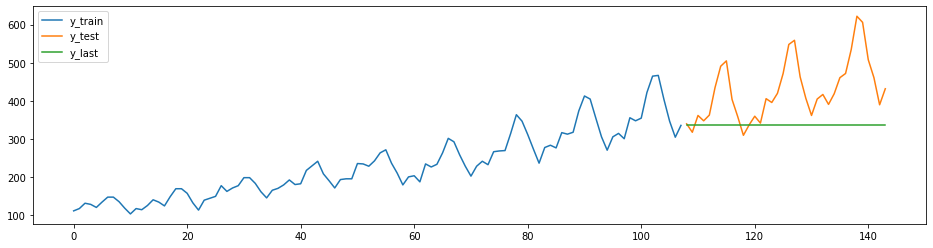

In [11]:
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_last"]);
smape_loss(y_last, y_test)

0.22001063912406713

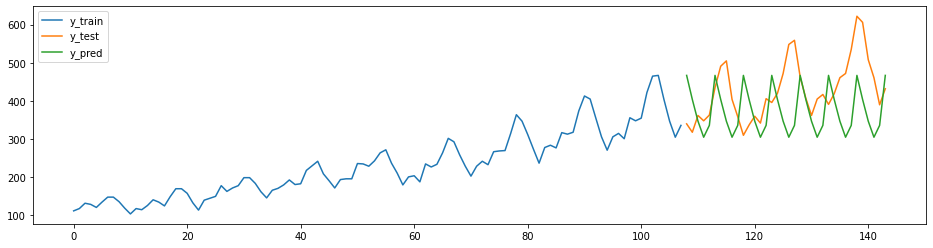

In [12]:
forecaster = NaiveForecaster(strategy="last", sp=5)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

we can predict a slice of any user defined length taking as input in the model the 

```python
forecast_indices = np.array(range(10))
```


### Optimizing automatically hyperparameters

In [13]:
len(fh)

36

In [14]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 20, name='sp')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    forecaster.set_params(**params)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh) 
    return smape_loss(y_pred, y_test)

In [15]:
from skopt import gp_minimize

res = gp_minimize(objective,                  # the function to minimize
                  space,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=20,# the number of evaluations of f 
                  random_state=1233)         

/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


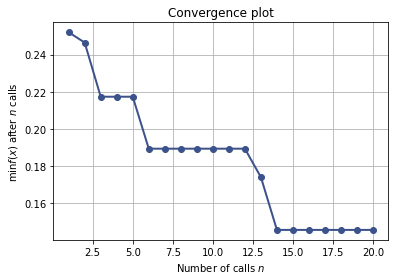

In [16]:
from skopt.plots import plot_convergence
plot_convergence(res);

In [17]:
def get_best_solution(res, model):
    
    # Get index with lowest error 
    idx = np.argmin(res['func_vals'])
    
    # get the names of the parameters tuned
    hyperparam_names = [x.name for x in  res.space]
    
    # Create a {param_name:value} dict containing each hyperparameter and its value
    param_value_dict = {name: res['x_iters'][idx][i] for i,name in enumerate(hyperparam_names)}
    
    # Set a new model with the best parameter values
    model.set_params(**param_value_dict)

    return model

    

In [18]:
forecaster = get_best_solution(res, forecaster)

0.145427686270316

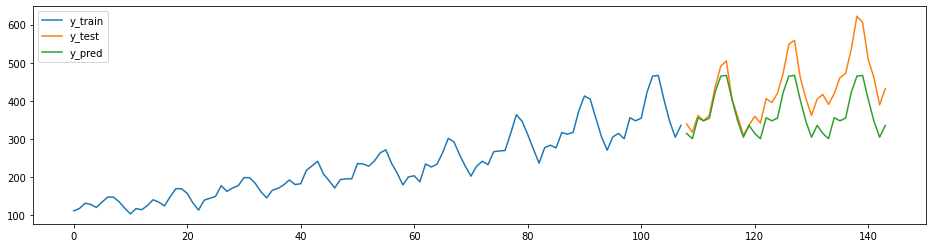

In [19]:
best_result_index = np

## Create model with the best parameters found
#forecaster.set_params(**{'sp':res['x_iters'][best_result_index][0]})
forecaster.fit(y_train)

## Make predictions
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)